In [1]:
%matplotlib ipympl

In [2]:
from matplotlib.pyplot import figure, subplots, subplot_mosaic, get_cmap, close
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from numpy import *
from numpy.linalg import *
from numpy.random import *
from numpy.fft import *

In [3]:
from pandas import read_csv, read_excel

In [4]:
from scipy.interpolate import CubicSpline
from scipy.io import whosmat, loadmat

In [5]:
myvars = locals()

# Load data into workspace and perform computations

In [6]:
_data = read_excel("../data/Sample data for battery use optimization r3.xlsx")

In [7]:
t_h = _data["Time (hrs)"].to_numpy()
grid_CO2_t = _data["Grid_CO2_hrs (kg)"].to_numpy()/907.185
excess_load_demand_MW = _data["Grid_Energy_hrs (kWh)"]/1e3
load_demand = excess_load_demand_MW.sum()
avail_solar_cap_MW = _data["DER_Solar1MW_Pwr (MW)"].to_numpy()

In [8]:
supply_df = read_csv("../data/gac_sol_1.0mw_supply-curve-aggregation.csv")

In [9]:
df_solarCapEx = read_excel("../data/SolarCapEX.xlsx")
solar_capacity_data = df_solarCapEx["Capacity (MW)"].to_numpy()
solar_cap_cost_data = df_solarCapEx["Solar Capital Cost"].to_numpy()

cs = CubicSpline(solar_capacity_data, solar_cap_cost_data)

In [10]:
df_batteryCapEx = read_excel("../data/BatteryStorageCapEx.xlsx", sheet_name="35 GWh")
battery_capacity_data = df_batteryCapEx["Power (MW)"].to_numpy()
NMC_cap_cost_data = df_batteryCapEx["NMC"].to_numpy()
NCA_cap_cost_data = df_batteryCapEx["NCA"].to_numpy()
LFP_cap_cost_data = df_batteryCapEx["LFP"].to_numpy()

NMC_cs = CubicSpline(battery_capacity_data, NMC_cap_cost_data)
NCA_cs = CubicSpline(battery_capacity_data, NCA_cap_cost_data)
LFP_cs = CubicSpline(battery_capacity_data, LFP_cap_cost_data)

In [11]:
_temp_data = load("../data/processed_results_theoryVariation_P2Eratio_0.25_outarray.npz")
for key, val in _temp_data.items():
    if isinstance(val, ndarray):
        myvars[key] = val.squeeze()

In [12]:
solar_sizes = linspace(0.0, 1000.0, 101)
battery_sizes = linspace(0.0, 100.0, 100//10 + 1)

SOLAR, BATTERY = meshgrid(solar_sizes, battery_sizes, indexing="ij")

In [13]:
def compute_LCOPR(OCS, PV2GRID, PR, N, E0):
    
    numerator = OCS - PV2GRID*N*PR
    denominator = N*E0

    if E0 == 0.0:
        return 0.0
    else:
        return numerator/denominator

In [14]:
def compute_LCOS(OCS, E_rated, N_EOL):

    numerator = OCS
    denominator = N_EOL*E_rated

    if E_rated == 0.0:
        return 0.0
    else:
        return numerator/denominator

In [15]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

In [16]:
solar_sizes = linspace(0.0, 1000.0, 101)
battery_sizes = linspace(0.0, 100.0, 11)

theoretical_total_cost_NMC = zeros((len(solar_sizes), len(battery_sizes)))
theoretical_total_cost_NCA = zeros((len(solar_sizes), len(battery_sizes)))
theoretical_total_cost_LFP = zeros((len(solar_sizes), len(battery_sizes)))

duration = 4.0

for i, nameplate_solar_cap in enumerate(solar_sizes[1:]):
    theoretical_total_cost_NMC[i+1, 1:] = cs(nameplate_solar_cap) + NMC_cs(battery_sizes[1:]/duration)
    theoretical_total_cost_NCA[i+1, 1:] = cs(nameplate_solar_cap) + NCA_cs(battery_sizes[1:]/duration)
    theoretical_total_cost_LFP[i+1, 1:] = cs(nameplate_solar_cap) + LFP_cs(battery_sizes[1:]/duration)

max_cost_common = max([theoretical_total_cost_NMC.max(), theoretical_total_cost_NCA.max(), theoretical_total_cost_LFP.max()])

In [17]:
theoretical_LCOPR_woReturns = zeros((101, 3))
theoretical_LCOPR_wReturns = zeros((101, 3))
solar_sizes = linspace(0.0, 1000.0, 101)
hours_shift = array([-4, 0, 4])

for i, nameplate_solar_cap in enumerate(solar_sizes):
    for j, shift in enumerate(hours_shift):
        theoretical_LCOPR_woReturns[i, j] = compute_LCOPR(OCS=cs(nameplate_solar_cap),  
                                                   PV2GRID=tot_solar_curtailed_optimal[i, j, 0], 
                                                   PR=0.0, 
                                                   N=30, 
                                                   E0=tot_solar[i, j, 0], 
                                                   )
        theoretical_LCOPR_wReturns[i, j] = compute_LCOPR(OCS=cs(nameplate_solar_cap),  
                                                  PV2GRID=tot_solar_curtailed_optimal[i, j, 0], 
                                                  PR=48.0, 
                                                  N=30, 
                                                  E0=tot_solar[i, j, 0], 
                                                  )

In [18]:
battery_sizes = linspace(0.0, 100.0, 100//10 + 1)
batt_LCOS = zeros((3, len(battery_sizes)))

rated_duration_h = 4.0

for i, batt_size in enumerate(battery_sizes):
    
    if i == 0:
        continue
        
    batt_LCOS[0, i] = compute_LCOS(OCS=NMC_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size, 
                                   N_EOL=2000)
    batt_LCOS[1, i] = compute_LCOS(OCS=NCA_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size,
                                   N_EOL=1400)
    batt_LCOS[2, i] = compute_LCOS(OCS=LFP_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size,  
                                   N_EOL=6000)

In [19]:
_out_data = loadmat("../data/numCycle_output_mu_0.85_P2Eratio_0.25_MedianTemp_outmat.mat")
for key, val in _out_data.items():
    if isinstance(val, ndarray):
        myvars[key] = val.squeeze()

In [22]:
GridElectricityPrice = 160 # $/MWh

NMC_100MWh_cost = batt_LCOS[0, :] 
NCA_100MWh_cost = batt_LCOS[1, :]
LFP_100MWh_cost = batt_LCOS[2, :]

cost_no_batt = fractions_optimal[..., 0, 0]*theoretical_LCOPR_woReturns[:, 0, None] + fractions_optimal[..., 0, 2]*160
cost_w_batt_NMC = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*160 + NMC_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*160
    )
cost_w_batt_NCA = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*160 + NCA_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*160
    )
cost_w_batt_LFP = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*160 + LFP_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*160
    )

YrsOperation_noBatt = 30
YrsOperation_NMC = 2000/moveaxis(cycles_optimal, [0, 1, 2], [2, 0, 1])
YrsOperation_NCA = 1400/moveaxis(cycles_optimal, [0, 1, 2], [2, 0, 1])
YrsOperation_LFP = 6000/moveaxis(cycles_optimal, [0, 1, 2], [2, 0, 1])

system_lifetime_NMC = minimum(YrsOperation_noBatt, YrsOperation_NMC)
system_lifetime_NCA = minimum(YrsOperation_noBatt, YrsOperation_NCA)
system_lifetime_LFP = minimum(YrsOperation_noBatt, YrsOperation_LFP)

TCO_utility_noBatt = cs(nominal_site_sizes[:,None,None]) + (cost_no_batt[...,None]*load_demand)*YrsOperation_noBatt
TCO_utility_wBatt_NMC = cs(nominal_site_sizes[:,None, None]) + NMC_cs(pack_sizes[None, None,:]) + (cost_w_batt_NMC*load_demand)*system_lifetime_NMC
TCO_utility_wBatt_NCA = cs(nominal_site_sizes[:,None, None]) + NCA_cs(pack_sizes[None, None,:]) + (cost_w_batt_NCA*load_demand)*system_lifetime_NCA
TCO_utility_wBatt_LFP = cs(nominal_site_sizes[:,None, None]) + LFP_cs(pack_sizes[None, None,:]) + (cost_w_batt_LFP*load_demand)*system_lifetime_LFP

TCO_utility_noBatt_perKgCO2 = TCO_utility_noBatt/(carbon_subtracted_optimal*907.185*YrsOperation_noBatt)
TCO_utility_wBatt_NMC_perKgCO2 = TCO_utility_wBatt_NMC/(carbon_subtracted_optimal*907.185*system_lifetime_NMC)
TCO_utility_wBatt_NCA_perKgCO2 = TCO_utility_wBatt_NCA/(carbon_subtracted_optimal*907.185*system_lifetime_NCA)
TCO_utility_wBatt_LFP_perKgCO2 = TCO_utility_wBatt_LFP/(carbon_subtracted_optimal*907.185*system_lifetime_LFP)

TCO_utility_wBatt_NMC_perKgCO2[logical_or(TCO_utility_wBatt_NMC_perKgCO2.__abs__() > 1e5, ~isfinite(TCO_utility_wBatt_NMC_perKgCO2))] = 0.0
TCO_utility_wBatt_NCA_perKgCO2[logical_or(TCO_utility_wBatt_NCA_perKgCO2.__abs__() > 1e5, ~isfinite(TCO_utility_wBatt_NCA_perKgCO2))] = 0.0
TCO_utility_wBatt_LFP_perKgCO2[logical_or(TCO_utility_wBatt_LFP_perKgCO2.__abs__() > 1e5, ~isfinite(TCO_utility_wBatt_LFP_perKgCO2))] = 0.0

TCO_utility_wBatt_NMC_perKgCO2[0,...] = 0.0
TCO_utility_wBatt_NCA_perKgCO2[0,...] = 0.0
TCO_utility_wBatt_LFP_perKgCO2[0,...] = 0.0

max_common_TCO_utility = max([TCO_utility_wBatt_NMC_perKgCO2.max(), TCO_utility_wBatt_NCA_perKgCO2.max(), TCO_utility_wBatt_LFP_perKgCO2.max()])

/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/4121281795.py:25: RuntimeWarning: divide by zero encountered in divide
  YrsOperation_NMC = 2000/moveaxis(cycles_optimal, [0, 1, 2], [2, 0, 1])
/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/4121281795.py:26: RuntimeWarning: divide by zero encountered in divide
  YrsOperation_NCA = 1400/moveaxis(cycles_optimal, [0, 1, 2], [2, 0, 1])
/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/4121281795.py:27: RuntimeWarning: divide by zero encountered in divide
  YrsOperation_LFP = 6000/moveaxis(cycles_optimal, [0, 1, 2], [2, 0, 1])
/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/4121281795.py:38: RuntimeWarning: divide by zero encountered in divide
  TCO_utility_noBatt_perKgCO2 = TCO_utility_noBatt/(carbon_subtracted_optimal*907.185*YrsOperation_noBatt)
/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/4121281795.py:39: RuntimeWarning: divide by zero encountered in d

In [23]:
MSRP_dayCab = 334_313 # 396_183 
MSRP_sleeper = 412_000
SUB = 40_000
RC = 1_500

INS_dayCab = 11_700
INS_sleeper = 14_300
MAINT_dayCab = 0.055
MAINT_sleeper = 0.025

eta_residual = 0.25

BEV_penalty = 0.5 # $/mile

AVG_VMT = 60_136.21
TOT_VMT = 56_015_092.23

GridElectricityPrice = 160 # $/MWh

num_trucks = 1825

YrsOperation = 5

IC_dayCab = MSRP_dayCab - SUB + RC
IC_sleeper = MSRP_sleeper - SUB + RC

NMC_100MWh_cost = batt_LCOS[0, :] 
NCA_100MWh_cost = batt_LCOS[1, :] 
LFP_100MWh_cost = batt_LCOS[2, :] 

cost_no_batt = fractions_optimal[..., 0, 0]*theoretical_LCOPR_woReturns[:, 0, None] + fractions_optimal[..., 0, 2]*GridElectricityPrice
cost_w_batt_NMC = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*GridElectricityPrice + NMC_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*GridElectricityPrice
    )
cost_w_batt_NCA = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*GridElectricityPrice + NCA_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*GridElectricityPrice
    )
cost_w_batt_LFP = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*GridElectricityPrice + LFP_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*GridElectricityPrice
    )

AOC_dayCab = INS_dayCab*num_trucks + MAINT_dayCab*TOT_VMT
AOC_sleeper = INS_sleeper*num_trucks + MAINT_sleeper*TOT_VMT

vehicle_efficiency = 2.575e-3 # MWh/mile
main_demand = vehicle_efficiency*TOT_VMT
# correction_term = main_demand - load_demand # MWh
correction_term = 0.0

TCO_dayCab_noDER = IC_dayCab*num_trucks + (AOC_dayCab + GridElectricityPrice*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_dayCab*num_trucks 
TCO_dayCab_noBatt = IC_dayCab*num_trucks + (AOC_dayCab + cost_no_batt*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_dayCab*num_trucks 
TCO_dayCab_wBatt_NMC = IC_dayCab*num_trucks + (AOC_dayCab + cost_w_batt_NMC*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_dayCab*num_trucks 
TCO_dayCab_wBatt_NCA = IC_dayCab*num_trucks + (AOC_dayCab + cost_w_batt_NCA*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_dayCab*num_trucks 
TCO_dayCab_wBatt_LFP = IC_dayCab*num_trucks + (AOC_dayCab + cost_w_batt_LFP*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_dayCab*num_trucks 

TCO_sleeper_noDER = IC_sleeper*num_trucks + (AOC_sleeper + GridElectricityPrice*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_sleeper*num_trucks 
TCO_sleeper_noBatt = IC_sleeper*num_trucks + (AOC_sleeper + cost_no_batt*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_sleeper*num_trucks 
TCO_sleeper_wBatt_NMC = IC_sleeper*num_trucks + (AOC_sleeper + cost_w_batt_NMC*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_sleeper*num_trucks 
TCO_sleeper_wBatt_NCA = IC_sleeper*num_trucks + (AOC_sleeper + cost_w_batt_NCA*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_sleeper*num_trucks 
TCO_sleeper_wBatt_LFP = IC_sleeper*num_trucks + (AOC_sleeper + cost_w_batt_LFP*load_demand + GridElectricityPrice*correction_term)*YrsOperation - eta_residual*MSRP_sleeper*num_trucks 

TCO_dayCab_noDER_perMile = TCO_dayCab_noDER/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_dayCab_noBatt_perMile = TCO_dayCab_noBatt/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_dayCab_wBatt_NMC_perMile = TCO_dayCab_wBatt_NMC/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_dayCab_wBatt_NCA_perMile = TCO_dayCab_wBatt_NCA/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_dayCab_wBatt_LFP_perMile = TCO_dayCab_wBatt_LFP/(TOT_VMT*YrsOperation) + BEV_penalty

TCO_sleeper_noDER_perMile = TCO_sleeper_noDER/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_sleeper_noBatt_perMile = TCO_sleeper_noBatt/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_sleeper_wBatt_NMC_perMile = TCO_sleeper_wBatt_NMC/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_sleeper_wBatt_NCA_perMile = TCO_sleeper_wBatt_NCA/(TOT_VMT*YrsOperation) + BEV_penalty
TCO_sleeper_wBatt_LFP_perMile = TCO_sleeper_wBatt_LFP/(TOT_VMT*YrsOperation) + BEV_penalty

In [24]:
min_common_TCO_perMile = max([TCO_dayCab_wBatt_NMC_perMile.min(), TCO_dayCab_wBatt_NMC_perMile.min(), TCO_dayCab_wBatt_NMC_perMile.min()])
max_common_TCO_perMile = max([TCO_dayCab_wBatt_NMC_perMile.max(), TCO_dayCab_wBatt_NMC_perMile.max(), TCO_dayCab_wBatt_NMC_perMile.max()])

# Figure S17: Hourly available solar capacity

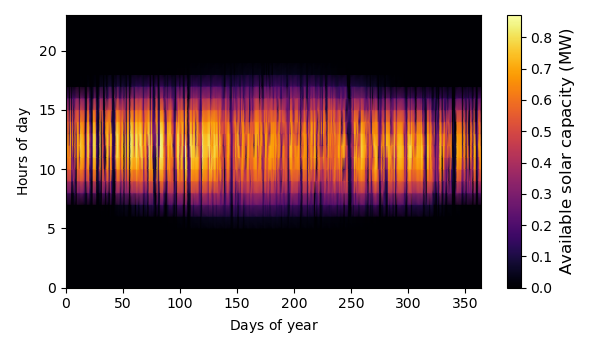

In [25]:
hours_in_day = arange(24)
days_in_year = arange(365)
HOURS, DAYS = meshgrid(days_in_year, hours_in_day)

avail_solar_cap_MW_mat = avail_solar_cap_MW.reshape((365,24)).T

fig, ax = subplots(figsize=(6, 3.5))

pmesh = ax.pcolormesh(HOURS, DAYS, avail_solar_cap_MW_mat, cmap="inferno", shading="gouraud")

ax.set_xlabel(r"$\mathrm{Days\ of\ year}$")
ax.set_ylabel(r"$\mathrm{Hours\ of\ day}$")

cbar = fig.colorbar(pmesh, ax=ax)
cbar.set_label(r"$\mathrm{Available\ solar\ capacity\ (MW)}$", fontsize=12)

fig.tight_layout()

fig.savefig("../figures/FigS17.pdf")

# Figure S18: Maximum excess CO2 emissions reduction for a solar farm 

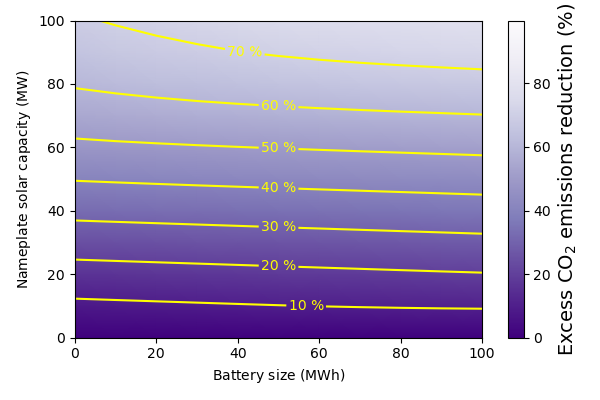

In [26]:
fig, ax = subplots(figsize=(6, 4))

line_color = "yellow"

pmesh = ax.pcolormesh(BATTERY, SOLAR, carbon_reduction_optimal[:,1,:], 
                      shading="gouraud", cmap="Purples_r", vmin=0.0, vmax=carbon_reduction_optimal[:,1,:].max())
CS = ax.contour(BATTERY, SOLAR, carbon_reduction_optimal[:,1,:], levels=array([10, 20, 30, 40, 50, 60, 70]), colors=line_color, vmin=0.0, vmax=27.0)

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

cbar = fig.colorbar(pmesh, ax=ax)
cbar.set_label(r"$\mathrm{Excess}\ \mathrm{CO}_{2}\ \mathrm{emissions\ reduction\ (\%)}$", fontsize=14)
ax.set_xlabel(r"$\mathrm{Battery\ size\ (MWh)}$")
ax.set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")

ax.set_xlim((0, 100))
ax.set_ylim((0, 100))

fig.tight_layout()
fig.align_labels()

fig.savefig("../figures/FigS18.pdf")

# Figure S19: The peak of solar availability at the hypothetical site is aligned with the peak of excess load demand

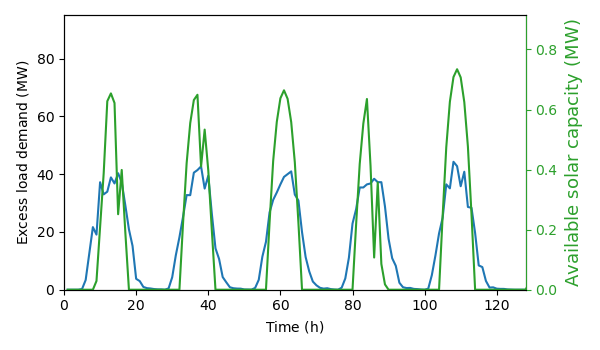

In [27]:
fig, ax = subplots(figsize=(6, 3.5))

ax.plot(t_h, excess_load_demand_MW)

ax.set_ylabel(r"$\mathrm{Excess\ load\ demand\ (MW)}$")

ax_twin = ax.twinx()
ax_twin.spines["right"].set_visible(True)
ax_twin.spines["right"].set_color("C2")
ax_twin.tick_params(which="both", colors="C2")

ax_twin.plot(t_h, avail_solar_cap_MW, "C2")
ax_twin.set_ylabel(r"$\mathrm{Available\ solar\ capacity\ (MW)}$", color="C2", fontsize=13)

ax.set_xlabel(r"$\mathrm{Time\ (h)}$")

ax.set_xlim((0, 128))

ax.set_ylim((0, None))
ax_twin.set_ylim((0, None))

fig.tight_layout()
fig.align_labels()

fig.savefig("../figures/FigS19.pdf")

# Figure S20: Artificially shifting the peak of excess load demand with respect to the peak of solar availability

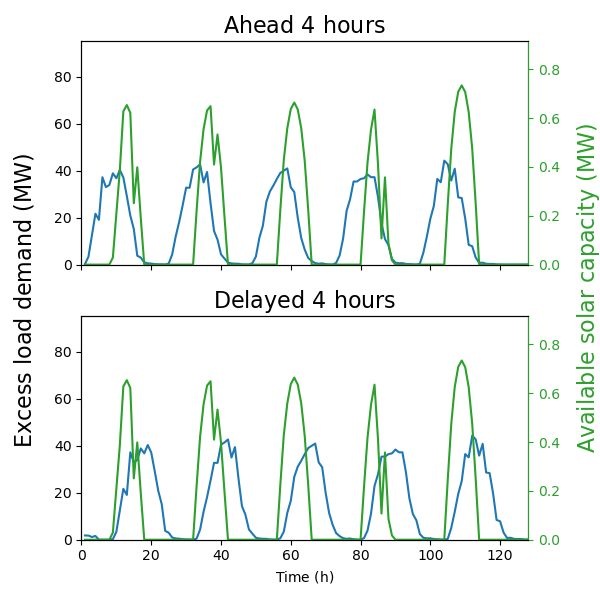

In [28]:
fig, ax = subplots(2, 1, figsize=(6, 6), sharex=True)

ax[0].plot(t_h, roll(excess_load_demand_MW, -4))
ax[0].set_title(r"$\mathrm{Ahead\ 4\ hours}$", fontsize=16)

ax_twin0 = ax[0].twinx()
ax_twin0.spines["right"].set_visible(True)
ax_twin0.spines["right"].set_color("C2")
ax_twin0.tick_params(which="both", colors="C2")

ax_twin0.plot(t_h, avail_solar_cap_MW, "C2")

ax[0].set_xlim((0, 128))

ax[0].set_ylim((0, None))
ax_twin0.set_ylim((0, None))

ax[1].plot(t_h, roll(excess_load_demand_MW, 4))
ax[1].set_title(r"$\mathrm{Delayed\ 4\ hours}$", fontsize=16)

ax_twin1 = ax[1].twinx()
ax_twin1.spines["right"].set_visible(True)
ax_twin1.spines["right"].set_color("C2")
ax_twin1.tick_params(which="both", colors="C2")

ax_twin1.plot(t_h, avail_solar_cap_MW, "C2")

ax[1].set_xlabel(r"$\mathrm{Time\ (h)}$")

ax[1].set_xlim((0, 128))

ax[1].set_ylim((0, None))
ax_twin1.set_ylim((0, None))

fig.supylabel(r"$\mathrm{Excess\ load\ demand\ (MW)}$", fontsize=16)

fig.tight_layout()
fig.align_labels()

fig.text(
    0.98, 0.52,
    r"$\mathrm{Available\ solar\ capacity\ (MW)}$", 
    ha="center", 
    va="center",
    rotation="vertical",
    color="C2", 
    fontsize=16, 
    )

fig.subplots_adjust(right=0.88)

fig.savefig("../figures/FigS20.pdf")

# Figure S21: maximum total excess CO2 emissions reduction under demand shifted scenarios

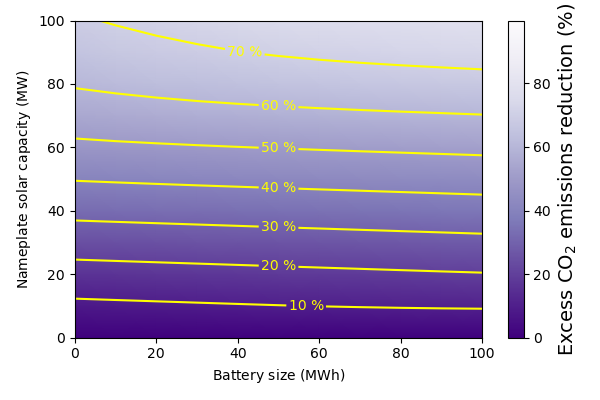

In [29]:
fig, ax = subplots(figsize=(6, 4))

line_color = "yellow"

pmesh = ax.pcolormesh(BATTERY, SOLAR, carbon_reduction_optimal[:,1,:], 
                      shading="gouraud", cmap="Purples_r", vmin=0.0, vmax=carbon_reduction_optimal[:,1,:].max())
CS = ax.contour(BATTERY, SOLAR, carbon_reduction_optimal[:,1,:], levels=array([10, 20, 30, 40, 50, 60, 70]), colors=line_color, vmin=0.0, vmax=27.0)

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

cbar = fig.colorbar(pmesh, ax=ax)
cbar.set_label(r"$\mathrm{Excess}\ \mathrm{CO}_{2}\ \mathrm{emissions\ reduction\ (\%)}$", fontsize=14)
ax.set_xlabel(r"$\mathrm{Battery\ size\ (MWh)}$")
ax.set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")

ax.set_xlim((0, 100))
ax.set_ylim((0, 100))

fig.tight_layout()
fig.align_labels()

fig.savefig("../figures/FigS21.pdf")

# Figure S22: Resource utilization for different combinations of nameplate solar capacity and battery size

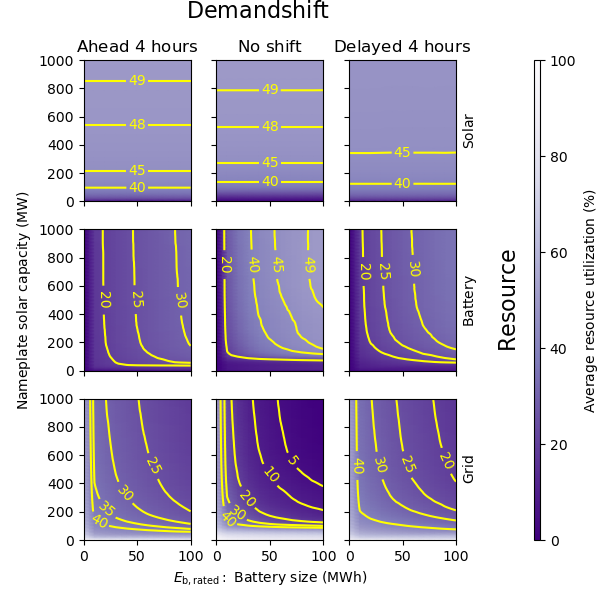

In [30]:
fig, ax = subplots(3, 3, figsize=(6, 6), sharex=True, sharey=True)

line_colors="yellow"

for i in range(3):
    for j in range(3):
        ax[i, j].pcolormesh(BATTERY, SOLAR, 1e2*fractions_optimal[:, j, :, i], shading="gouraud", cmap="Purples_r", vmin=0.0, vmax=100.0)

    CS = ax[0, i].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, i, :, 0], array([40, 45, 48, 49, 50]), colors=line_colors, vmin=0.0, vmax=100.0)
    ax[0, i].clabel(CS, CS.levels, inline=True, fontsize=10)

CS = ax[1, 0].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, 0, :, 1], array([20, 25, 30]), colors=line_colors, vmin=0.0, vmax=100.0)
ax[1, 0].clabel(CS, CS.levels, inline=True, fontsize=10, manual=[(20, 500), (40, 500), (100, 500)])

CS = ax[1, 1].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, 1, :, 1], array([20, 40, 45, 49]), colors=line_colors, vmin=0.0, vmax=100.0)
ax[1, 1].clabel(CS, CS.levels, inline=True, fontsize=10, manual=[(5, 750), (30, 750), (55, 750), (85, 750)])

CS = ax[1, 2].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, 2, :, 1], array([20, 25, 30]), colors=line_colors, vmin=0.0, vmax=100.0)
ax[1, 2].clabel(CS, CS.levels, inline=True, fontsize=10, manual=[(10, 700), (30, 700), (50, 700)])

CS = ax[2, 0].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, 0, :, 2], array([25, 30, 35, 40]), colors=line_colors, vmin=0.0, vmax=100.0)
ax[2, 0].clabel(CS, CS.levels, inline=True, fontsize=10, manual=[(64.2, 519), (37.5, 321), (20.9, 208), (9.8, 15.2)])

CS = ax[2, 1].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, 1, :, 2], array([5, 10, 20, 30, 40]), colors=line_colors, vmin=0.0, vmax=100.0)
ax[2, 1].clabel(CS, CS.levels, inline=True, fontsize=10, manual=[(70.1, 555), (48.9, 449), (27.7, 287), (19.4, 188), (10.2, 145)])

CS = ax[2, 2].contour(BATTERY, SOLAR, 1e2*fractions_optimal[:, 2, :, 2], array([20, 25, 30, 40]), colors=line_colors, vmin=0.0, vmax=100.0)
ax[2, 2].clabel(CS, CS.levels, inline=True, fontsize=10, manual=[(90, 555), (53, 527), (29, 527), (8.7, 527)])

ax[-1, -1].set_ylim((0, 1000))
ax[-1, -1].set_xlim((0, 100))

for n in range(3):
    for m in range(3):
        ax[n, m].ticklabel_format(style="plain")

ax[0, 0].set_title(r"$\mathrm{Ahead\ 4\ hours}$")
ax[0, 1].set_title(r"$\mathrm{No\ shift}$")
ax[0, 2].set_title(r"$\mathrm{Delayed\ 4\ hours}$")

ax[0, -1].set_ylabel(r"$\mathrm{Solar}$")
ax[1, -1].set_ylabel(r"$\mathrm{Battery}$")
ax[2, -1].set_ylabel(r"$\mathrm{Grid}$")

for n in range(3):
    ax[n, -1].yaxis.set_label_position('right')

ax[-1, 1].set_xlabel(r"$E_{\mathrm{b,rated}}:\ \mathrm{Battery\ size\ (MWh)}$")
ax[1, 0].set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")

fig.tight_layout()

cax = fig.add_axes([0.89, 0.1, 0.01, 0.9-0.1])
cbar = fig.colorbar(ScalarMappable(Normalize(vmin=0.0, vmax=100.0), cmap="Purples_r"), cax=cax)
cbar.set_label(r"$\mathrm{Average\ resource\ utilization\ (\%)}$")

fig.text(
    0.85, 0.5, 
    r"$\mathrm{Resource}$", 
    fontsize=16, 
    rotation="vertical", 
    ha="center", va="center"
    )

fig.suptitle(r"$\mathrm{Demand shift}$", ha="center", va="center", x=0.43, fontsize=16)

fig.subplots_adjust(right=0.76, top=0.9, bottom=0.1)

fig.savefig("../figures/FigS22.pdf")

# Figure S23: Total electricity cost (TEC) for different nameplate solar capacity and battery size combinations

/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/799742577.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


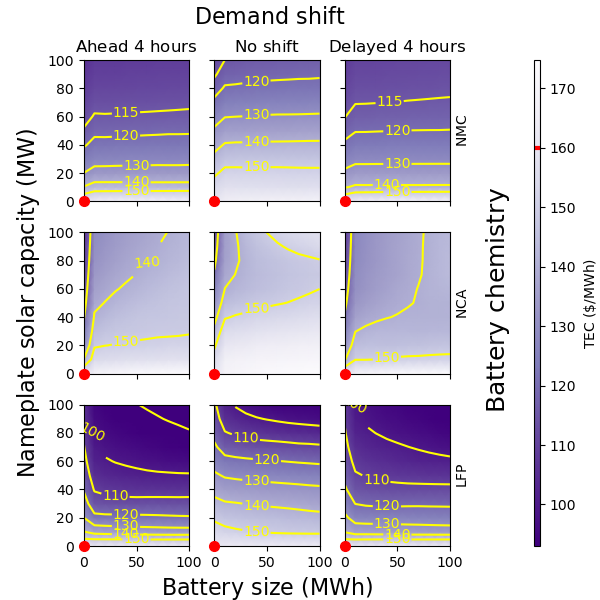

In [31]:
fig, ax = subplots(3, 3, figsize=(6, 6), sharex=True, sharey=True)

NMC_100MWh_cost = batt_LCOS[0, :] 
NCA_100MWh_cost = batt_LCOS[1, :]
LFP_100MWh_cost = batt_LCOS[2, :]

cost_w_batt_NMC = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*160 + NMC_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*160
    )
cost_w_batt_NCA = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*160 + NCA_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*160
    )
cost_w_batt_LFP = (
    fractions_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] 
    + fractions_optimal[..., 1]*(fractions_batt_charge_optimal[..., 0]*theoretical_LCOPR_woReturns[..., None] + fractions_batt_charge_optimal[..., 1]*160 + LFP_100MWh_cost[None, None, :]) 
    + fractions_optimal[..., 2]*160
    )

max_cost = max([cost_w_batt_NMC.max(), cost_w_batt_NCA.max(), cost_w_batt_LFP.max()])
min_cost = max([cost_w_batt_NMC.min(), cost_w_batt_NCA.min(), cost_w_batt_LFP.min(), 0.0])

line_colors = "yellow"

for i in range(3):

    ax[0, i].pcolormesh(BATTERY, SOLAR, cost_w_batt_NMC[:,i,:], shading="gouraud", cmap="Purples_r", vmin=min_cost, vmax=max_cost)
    CS0 = ax[0, i].contour(BATTERY, SOLAR, cost_w_batt_NMC[:,i,:], array([115, 120, 130, 140, 150]), colors=line_colors, vmin=0.0, vmax=max_cost)
    ax[0, i].clabel(CS0, CS0.levels, inline=True, fontsize=10)
    
    
    ax[1, i].pcolormesh(BATTERY, SOLAR, cost_w_batt_NCA[:,i,:], shading="gouraud", cmap="Purples_r", vmin=min_cost, vmax=max_cost)
    CS1 = ax[1, i].contour(BATTERY, SOLAR, cost_w_batt_NCA[:,i,:], array([120, 140, 150]), colors=line_colors, vmin=0.0, vmax=max_cost)
    ax[1, i].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    
    
    ax[2, i].pcolormesh(BATTERY, SOLAR, cost_w_batt_LFP[:,i,:], shading="gouraud", cmap="Purples_r", vmin=min_cost, vmax=max_cost)
    CS2 = ax[2, i].contour(BATTERY, SOLAR, cost_w_batt_LFP[:,i,:], array([90, 100, 110, 120, 130, 140, 150]), colors=line_colors, vmin=0.0, vmax=max_cost)
    ax[2, i].clabel(CS2, CS2.levels, inline=True, fontsize=10)

ax[0, -1].set_ylabel(r"$\mathrm{NMC}$")
ax[1, -1].set_ylabel(r"$\mathrm{NCA}$")
ax[2, -1].set_ylabel(r"$\mathrm{LFP}$")

ax[0, 0].set_title(r"$\mathrm{Ahead\ 4\ hours}$")
ax[0, 1].set_title(r"$\mathrm{No\ shift}$")
ax[0, 2].set_title(r"$\mathrm{Delayed\ 4\ hours}$")

for i in range(3):
    ax[i, -1].yaxis.set_label_position("right")
    for j in range(3):
        ax[i, j].set(xlim=(0, 100), ylim=(0, 100))
        ax[i, j].scatter(array([0.0]), array([0.0]), color="r", marker="o", s=7**2, zorder=5, clip_on=False)

ax[1, 0].set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$", fontsize=16)
ax[-1, 1].set_xlabel(r"$\mathrm{Battery\ size\ (MWh)}$", fontsize=16)
fig.suptitle(r"$\mathrm{Demand\ shift}$", va="center", ha="center", x=0.45, y=0.97, fontsize=16)

fig.text(
    0.83, 0.5, 
    r"$\mathrm{Battery\ chemistry}$",
    fontsize=18, 
    va="center", ha="center", 
    rotation="vertical"
    )

cax = fig.add_axes([0.89, 0.09, 0.01, 0.9-0.09])
cbar = fig.colorbar(ScalarMappable(Normalize(vmin=min_cost, vmax=max_cost), cmap="Purples_r"), cax=cax)
cbar.set_label(r"$\mathrm{TEC\ (\$/MWh)}$")
cbar.ax.axhline(160, ls="-", color="r", lw=3.0)

ticks = cbar.ax.get_yticks()
highlight_tick = min(ticks, key=lambda x: abs(x - 160))

# Get the tick labels and color the specific tick label red
for tick_label in cbar.ax.get_yticklabels():
    if tick_label.get_text() == r"$\mathdefault{" + f"{highlight_tick:.0f}" + r"}$":
        tick_label.set_color('red')

fig.tight_layout()
fig.align_labels()

fig.subplots_adjust(bottom=0.09, right=0.75, top=0.9)

fig.savefig("../figures/FigS23.pdf")

# Figure S24: TCO/kg of CO2 removed for different combinations of nameplate solar capacity and battery size

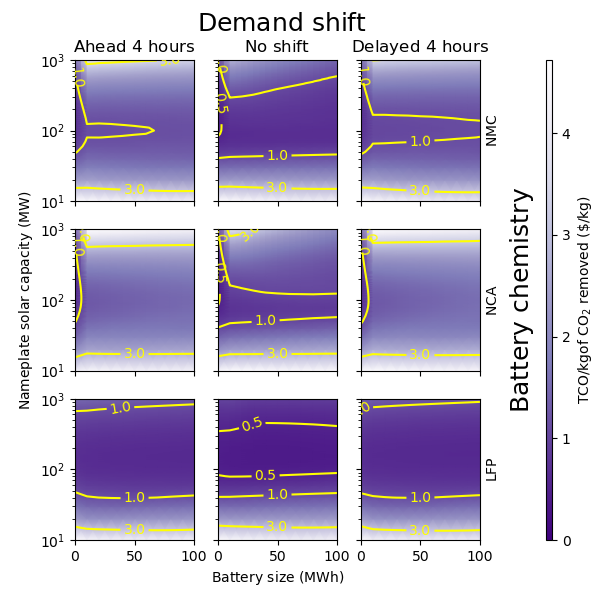

In [32]:
fig, ax = subplots(3, 3, figsize=(6, 6), sharex=True, sharey=True)

y_threshold = 100
line_color = "yellow"

for i in range(3):

    ax[0, i].pcolormesh(BATTERY, SOLAR, TCO_utility_wBatt_NMC_perKgCO2[:, i, :], shading="gouraud", cmap="Purples_r")
    CS0 = ax[0, i].contour(BATTERY, SOLAR, TCO_utility_wBatt_NMC_perKgCO2[:, i, :], array([0.5, 1.0, 3.0]), colors=line_color, vmin=0.0, vmax=4.0)
    ax[0, i].clabel(CS0, inline=True, fontsize=10)
    
    ax[1, i].pcolormesh(BATTERY, SOLAR, TCO_utility_wBatt_NCA_perKgCO2[:, i, :], shading="gouraud", cmap="Purples_r")
    CS1 = ax[1, i].contour(BATTERY, SOLAR, TCO_utility_wBatt_NCA_perKgCO2[:, i, :], array([0.5, 1.0, 3.0]), colors=line_color, vmin=0.0, vmax=4.0)
    ax[1, i].clabel(CS1, inline=True, fontsize=10)
    
    ax[2, i].pcolormesh(BATTERY, SOLAR, TCO_utility_wBatt_LFP_perKgCO2[:, i, :], shading="gouraud", cmap="Purples_r")
    CS2 = ax[2, i].contour(BATTERY, SOLAR, TCO_utility_wBatt_LFP_perKgCO2[:, i, :], array([0.5, 1.0, 3.0]), colors=line_color, vmin=0.0, vmax=4.0)
    ax[2, i].clabel(CS2, inline=True, fontsize=10)

ax[0, 0].set_title(r"$\mathrm{Ahead\ 4\ hours}$")
ax[0, 1].set_title(r"$\mathrm{No\ shift}$")
ax[0, 2].set_title(r"$\mathrm{Delayed\ 4\ hours}$")

ax[0, -1].set_ylabel(r"$\mathrm{NMC}$")
ax[1, -1].set_ylabel(r"$\mathrm{NCA}$")
ax[2, -1].set_ylabel(r"$\mathrm{LFP}$")

ax[-1, 1].set_xlabel(r"$\mathrm{Battery\ size\ (MWh)}$")
ax[1, 0].set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")

for i in range(3):
    ax[i, -1].yaxis.set_label_position("right")
    for j in range(3):
        ax[i, j].set(xlim=(0.0, 100.0), ylim=(1e1, 1e3))
        # ax[i, j].ticklabel_format(style="plain")
        ax[i, j].set_yscale("log")

cax = fig.add_axes([0.91, 0.1, 0.01, 0.9-0.1])
cbar = fig.colorbar(ScalarMappable(Normalize(vmin=0.0, vmax=max_common_TCO_utility), cmap="Purples_r"), cax=cax)
cbar.set_label(r"$\mathrm{TCO/kg of}\ \mathrm{CO}_{2}\ \mathrm{removed\ (\$/kg)}$")

fig.suptitle(r"$\mathrm{Demand\ shift}$", x=0.47, y=0.96, ha="center", va="center", fontsize=18)

fig.text(
    0.87, 0.5, 
    r"$\mathrm{Battery\ chemistry}$", 
    va="center", ha="center", 
    fontsize=18, 
    rotation="vertical"
    )

fig.subplots_adjust(right=0.8, bottom=0.1, top=0.9)

fig.savefig("../figures/FigS24.pdf")

# Figure S25: TCO/mile of the HDCV fleet for different combinations of nameplate capacity and battery size

/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_46749/1588227882.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


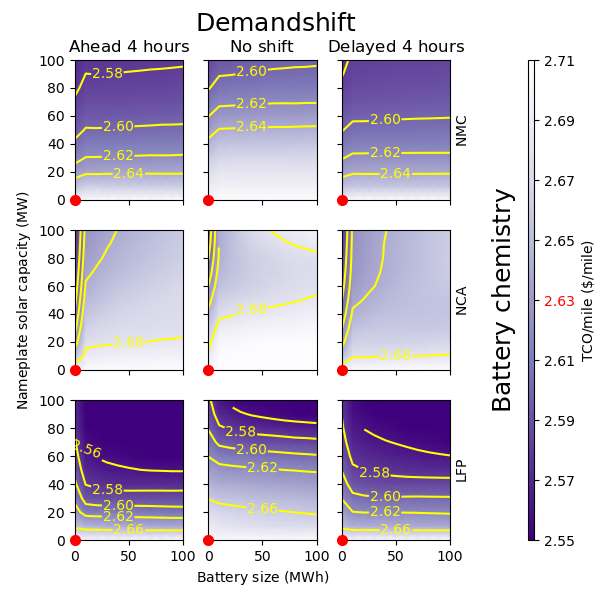

In [39]:
fig, ax = subplots(3, 3, figsize=(6, 6), sharex=True, sharey=True)

line_color="yellow"

for i in range(3):
    ax[0, i].pcolormesh(BATTERY, SOLAR, TCO_dayCab_wBatt_NMC_perMile[:,i,:], shading="gouraud", cmap="Purples_r", vmin=2.55, vmax=2.71)
    CS0 = ax[0, i].contour(BATTERY, SOLAR, TCO_dayCab_wBatt_NMC_perMile[:, i, :], array([2.56, 2.58, 2.60, 2.62, 2.64]), colors=line_color, vmin=0.5*min_common_TCO_perMile, vmax=max_common_TCO_perMile)
    ax[0, i].clabel(CS0, CS0.levels, inline=True, fontsize=10)

    ax[1, i].pcolormesh(BATTERY, SOLAR, TCO_dayCab_wBatt_NCA_perMile[:,i,:], shading="gouraud", cmap="Purples_r", vmin=2.55, vmax=2.71)
    CS1 = ax[1, i].contour(BATTERY, SOLAR, TCO_dayCab_wBatt_NCA_perMile[:, i, :], array([2.60, 2.62, 2.64, 2.68]), colors=line_color, vmin=0.5*min_common_TCO_perMile, vmax=max_common_TCO_perMile)
    ax[1, i].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    
    ax[2, i].pcolormesh(BATTERY, SOLAR, TCO_dayCab_wBatt_LFP_perMile[:,i,:], shading="gouraud", cmap="Purples_r", vmin=2.55, vmax=2.71)
    CS2 = ax[2, i].contour(BATTERY, SOLAR, TCO_dayCab_wBatt_LFP_perMile[:, i, :], array([2.56, 2.58, 2.60, 2.62, 2.66]), colors=line_color, vmin=0.5*min_common_TCO_perMile, vmax=max_common_TCO_perMile)
    ax[2, i].clabel(CS2, CS2.levels, inline=True, fontsize=10)

    for j in range(3):
        ax[i, j].scatter(array([0.0]), array([0.0]), color="r", marker="o", s=7**2, zorder=5, clip_on=False)

ax[0, 0].set_title(r"$\mathrm{Ahead\ 4\ hours}$")
ax[0, 1].set_title(r"$\mathrm{No\ shift}$")
ax[0, 2].set_title(r"$\mathrm{Delayed\ 4\ hours}$")

ax[0, -1].set_ylabel(r"$\mathrm{NMC}$")
ax[1, -1].set_ylabel(r"$\mathrm{NCA}$")
ax[2, -1].set_ylabel(r"$\mathrm{LFP}$")

ax[-1, 1].set_xlabel(r"$\mathrm{Battery\ size\ (MWh)}$")
ax[1, 0].set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")

for i in range(3):
    ax[i, -1].yaxis.set_label_position("right")
    for j in range(3):
        ax[i, j].set(xlim=(0.0, 100.0), ylim=(0.0, 100.0))

cax = fig.add_axes([0.88, 0.1, 0.01, 0.9-0.1])
cbar = fig.colorbar(ScalarMappable(Normalize(vmin=2.55, vmax=2.71), cmap="Purples_r"), cax=cax) 
cbar.set_label(r"$\mathrm{TCO/mile\ (\$/mile)}$")
cbar.ax.axhline(1.63, ls="-", color="r", lw=3.0)

cbar.ax.set_yticks(arange(2.55, 2.71, 0.02))
ticks = cbar.ax.get_yticks()
highlight_tick = min(ticks, key=lambda x: abs(x - 2.63))

# Get the tick labels and color the specific tick label red
for tick_label in cbar.ax.get_yticklabels():
    if tick_label.get_text() == f"{highlight_tick:.2f}":
        tick_label.set_color('red')

fig.suptitle(r"$\mathrm{Demand shift}$", x=0.46, y=0.96, ha="center", va="center", fontsize=18)

fig.text(
    0.84, 0.5, 
    r"$\mathrm{Battery\ chemistry}$", 
    va="center", ha="center", 
    fontsize=18, 
    rotation="vertical"
    )

fig.tight_layout()

fig.subplots_adjust(right=0.75, bottom=0.1, top=0.9)
fig.savefig("../figures/FigS25.pdf")